In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [2]:
data = pd.read_json("parsed/pros.json")
#data.set_index(['id','f'],inplace=True)
data.head()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month,id
0,0,2,78.612690,0.00,0.00,92.74,0.00,0.00,0.00,0.0,0,12,31B7B257486DB2CAA81EEFBD9D96DCA9
1,178,2,84.570930,-0.47,-27.81,93.01,34.41,-2280.19,32.83,0.0,0,12,31B7B257486DB2CAA81EEFBD9D96DCA9
2,179,2,84.604256,41.38,0.81,89.41,513.38,1307.49,5.50,0.0,0,12,31B7B257486DB2CAA81EEFBD9D96DCA9
3,180,2,84.637580,76.66,13.46,93.74,1268.86,621.75,47.70,0.0,0,12,31B7B257486DB2CAA81EEFBD9D96DCA9
4,181,2,84.670906,129.49,39.35,95.05,1267.21,620.95,20.55,0.0,0,12,31B7B257486DB2CAA81EEFBD9D96DCA9


In [3]:
data.describe()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month
count,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.000000,450106.0
mean,5417.263838,115.158216,234.125024,-8.775638,-38.274413,818.518538,-0.018652,6.006745,4.680627,0.504661,1.749330,12.0
std,3203.560686,89.146347,123.361051,2467.638297,3037.244359,522.319353,1179.774692,1427.347071,623.053720,0.446657,1.698999,0.0
min,0.000000,0.000000,8.015506,-4082.120000,-5214.970000,14.680000,-4235.440000,-4264.170000,-2632.920000,0.000000,0.000000,12.0
25%,2737.000000,2.000000,134.396073,-2283.627500,-2774.745000,359.820000,-800.920000,-1112.615000,-396.397500,0.000000,0.000000,12.0
50%,5299.000000,131.000000,230.395325,21.400000,-30.170000,750.080000,0.000000,0.000000,0.000000,0.500000,1.000000,12.0
75%,7886.000000,185.000000,323.856013,2221.557500,2717.227500,1223.937500,826.422500,1143.987500,397.720000,1.000000,3.000000,12.0
max,17075.000000,282.000000,717.361000,4083.780000,5215.460000,2033.330000,4771.400000,4032.180000,2747.180000,1.000000,7.000000,12.0


In [4]:
print(f"Unique plays: {data.groupby(['pt','id']).size().size}")

Unique plays: 221


<IPython.core.display.Javascript object>


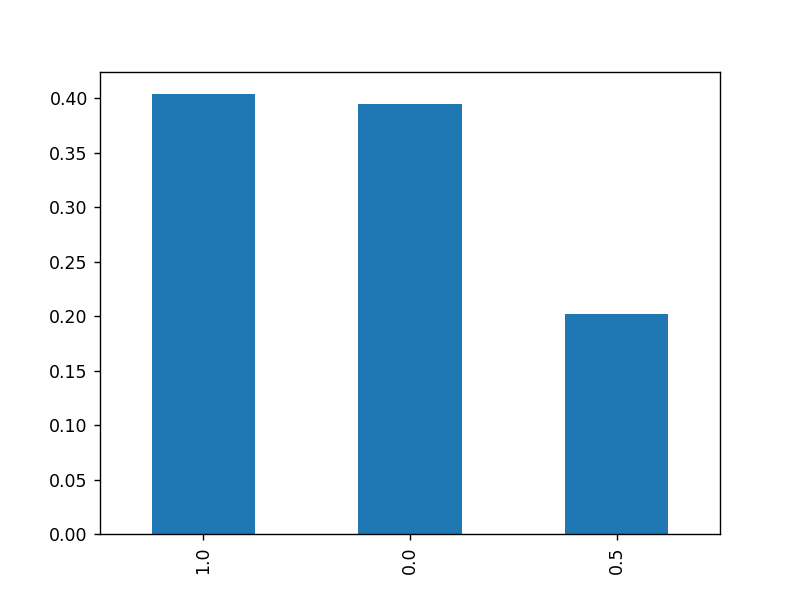

In [5]:
(data.scorer.value_counts() / len(data)).plot(kind='bar')
plt.show()

This actually shows the number of frames captured in points with each scorer,
but in fact the more interesting question is the number of plays with each
label. We can show the distribution of this too.

<IPython.core.display.Javascript object>


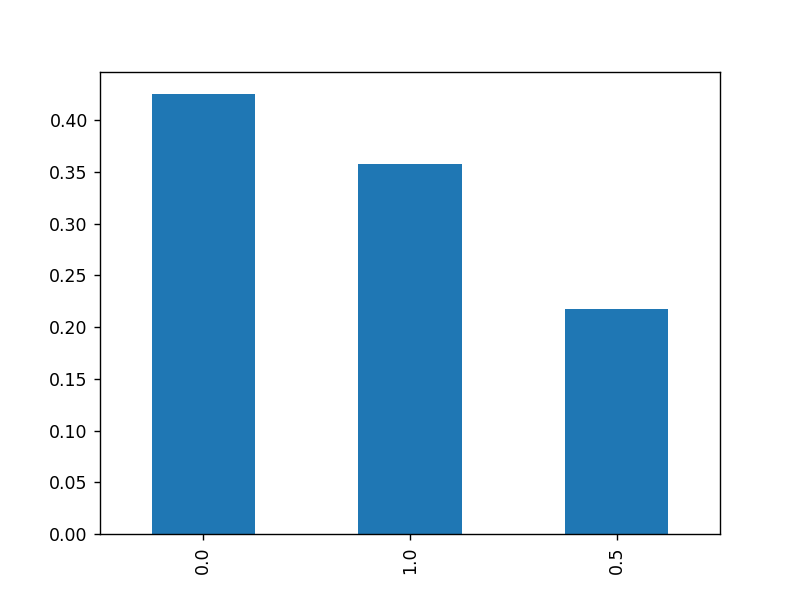

In [6]:
scorers = data.groupby(['id','pt']).agg('mean')['scorer']
(scorers.value_counts() / len(scorers)).plot(kind='bar')
plt.show()

In [7]:
id = data.id.unique()[8]
data.loc[data.id==id, "scorer"].value_counts()

onegame = data.loc[data.id==id]
onepoint = onegame.loc[data.pt==1]


Here's a fun way to examine this data. We can extract one point and animate the ball as it moves around the field.

<IPython.core.display.Javascript object>


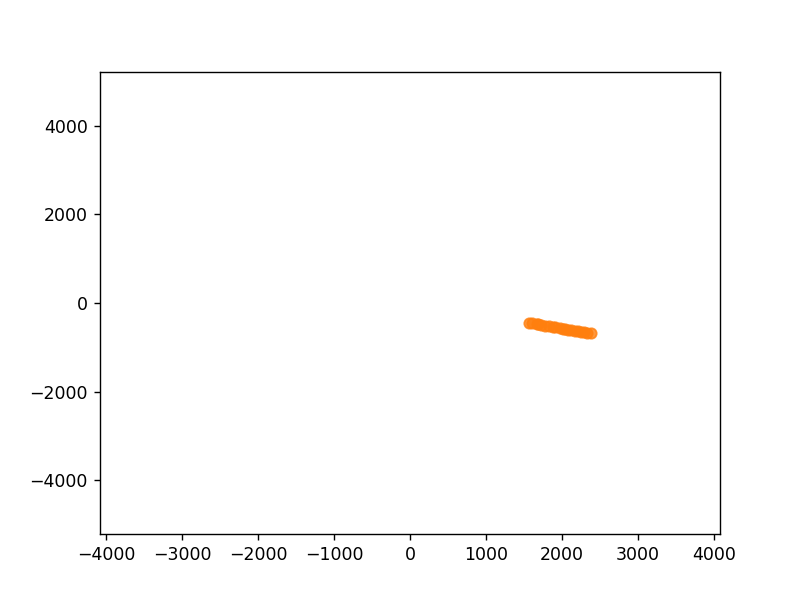

In [9]:
x = onepoint.x.values
y = onepoint.y.values
color=['C0','C1'][int(onepoint.scorer.mode()[0])]
interval=7
tail = 20
fig,ax = plt.subplots()
WIDTH = 4083
HEIGHT = 5215

# ===============
#%matplotlib notebook

ln, = plt.plot([], [], 'o', c=color, alpha=0.8)

def init():
    ax.set_xlim(-WIDTH,WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    return ln,

def update(frame):
    #print(frame)
    ln.set_data(x[max(0,frame-tail):frame], y[max(0,frame-tail):frame])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(len(x)),
                    init_func=init, blit=True, interval=interval)
plt.show()

We can learn more about how our variables are distributed by looking at the
location of the ball in the last frame of each play. We should expect all the
scores by team 0 to appear on one end of the field and the scores by team 1 on
the other end of the field, with some neutral balls on the ground in the midfield.

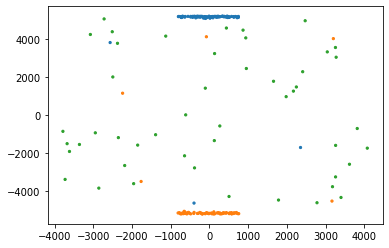

In [10]:
%matplotlib inline
gb = data.groupby(['id', 'pt'])
last_fn = lambda s: s.iloc[-1]
#scorers = gb['scorer'].agg({'scorer':pd.Series.mode, 'ending_x': x_fn, 'ending_y': y_fn
final_seconds = gb.agg({'scorer':pd.Series.mode, 'x':last_fn, 'y':last_fn})

plt.figure()
color_fn = lambda scorer: f"C{int(scorer)}" if scorer % 1 == 0 else "C2"
plt.scatter(final_seconds.x, final_seconds.y, s=5, c=final_seconds.scorer.map(color_fn))
plt.show()

So we can reasonably affirm these relationships:

| Team 0 | Team 1 |
|--|--|
| `+y` | `-y` |

We notice that there's a lot of data clumped in the middle of the field, which
doesn't make sense--the ball will only end there by chance. We look closer at
these points to find the discrepancy.

In [11]:
#plt.figure()
is_weird = (final_seconds.y.abs() < 5000)
is_not_weird = (final_seconds.y.abs() > 5000)
print(f"{is_weird.mean():.2%}")

24.89%


Let's look at those last-second ball locations again, to see if they make more
sense now.

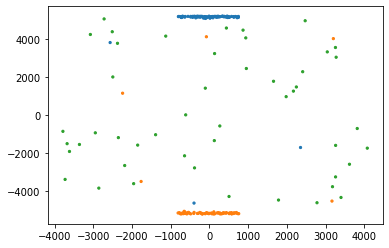

Number of points: 221


In [13]:
gb = data.groupby(['id','pt'])
final_seconds = gb.agg({'scorer':pd.Series.mode, 'x':last_fn, 'y':last_fn})

plt.figure()
color_fn = lambda scorer: f"C{int(scorer)}" if scorer % 1 == 0 else "C2"
plt.scatter(final_seconds.x, final_seconds.y, s=5, c=final_seconds.scorer.map(color_fn))
plt.show()
print("Number of points:", len(final_seconds))

There's still a lot of blue
and orange points scattered around the midfield. I'm not sure why that would be.
Something like overtime might be the culprit, although I haven't figured out
exactly how that could be the case.

## Training

We assign the replays to test and train by IDs, so that we don't have data from the same replay in both the training and testing sets.

In [14]:
train_ids, test_ids = train_test_split(data.id.unique())

data['x_abs'] = data.x.abs()

features = ['x', 'y', 'z', 'dx', 'dy', 'dz','x_abs']

X_train = data.loc[data.id.isin(train_ids), features]
y_train = data.loc[data.id.isin(train_ids), 'scorer']
X_test = data.loc[data.id.isin(test_ids), features]
y_test = data.loc[data.id.isin(test_ids), 'scorer']
#X_train, X_test, y_train, y_test = train_test_split(X, gb['scorer'])

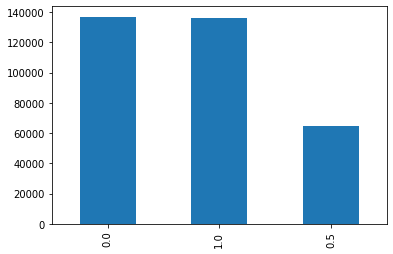

In [15]:
# Check for bias in training data
plt.figure()
y_train.value_counts().plot(kind='bar')

First we'll see how effective a simple logistic regression can be.

In [16]:
reclass = {0:0,1:1,0.5:2,2:2}
y_train = y_train.map(reclass)
y_test = y_test.map(reclass)

model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = model.predict(X_test)
print(f"Test accuracy: {(y_pred == y_test).mean():.2%}")

Test accuracy: 41.02%


Because our most common class covers just over 50% of the testing data, this
isn't really a significant result. We examine a confusion matrix below to see
where these errors are coming from.

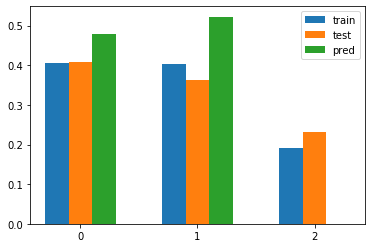

In [18]:
width = 0.2
xticks  = np.arange(3)
labels, counts = np.unique(y_pred, return_counts=True)
counts = [(y_pred == n).mean() for n in [0,1,2]]

plt.bar(xticks - width, y_train.value_counts() / len(y_train), width, label='train')
plt.bar(xticks, y_test.value_counts() / len(y_test),width, label='test')
plt.bar(xticks + width, counts, width, label='pred')
plt.xticks(xticks)
plt.legend()

plt.show()

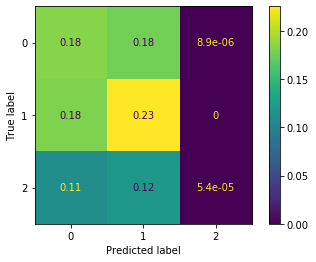

In [19]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)/len(y_test), [0,1,2]).plot()

So our model tends to overpredict on one particular class. Not sure why that is,
it's not even choosing the most common class in the training set.